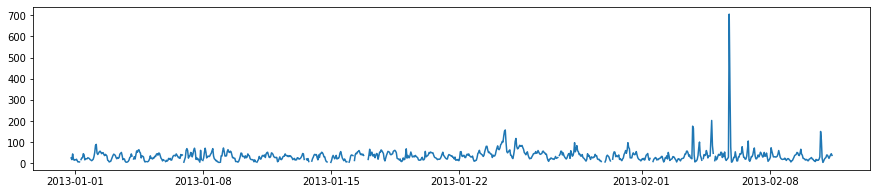

In [117]:
# load JSON
import json
import pandas as pd
 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])
df.y.dropna()
df = data[0:1000]

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
plt.figure(figsize=(15,3))
plt.plot(df['ds'],df['y'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


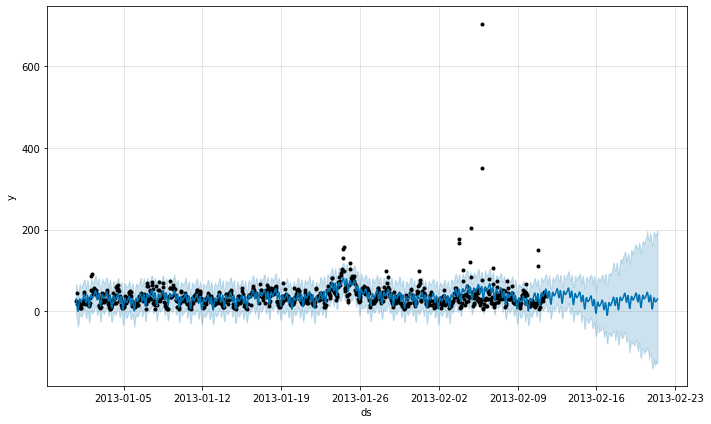

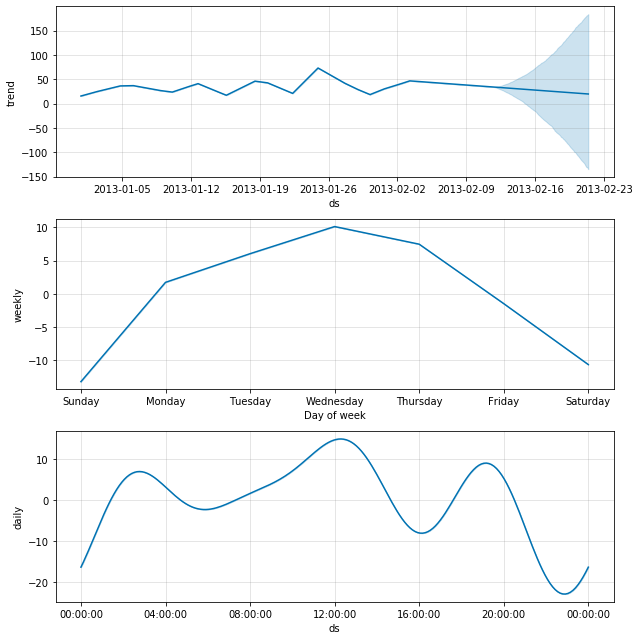

In [73]:
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=240, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [74]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='20 days', period='5 days', horizon ='10 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2013-01-22 10:00:00 and 2013-02-01 10:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-01-22 11:00:00,44.537200,30.290148,58.668801,44.0,2013-01-22 10:00:00
1,2013-01-22 12:00:00,45.725424,31.133630,59.569819,39.0,2013-01-22 10:00:00
2,2013-01-22 13:00:00,44.023237,29.176914,58.122048,45.0,2013-01-22 10:00:00
3,2013-01-22 14:00:00,39.784172,26.085243,53.063931,36.0,2013-01-22 10:00:00
4,2013-01-22 15:00:00,34.216350,20.761446,48.083428,34.0,2013-01-22 10:00:00


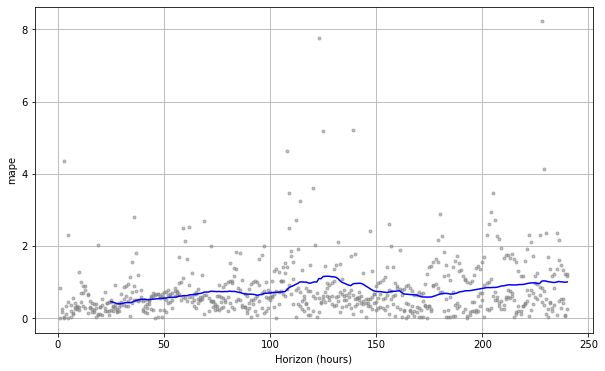

In [75]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [76]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 76.18826924583499%
SMAPE = 21.293962944153577%


In [7]:
#import pickle
#pkl_path = "franklin-d-roosevelt/PM10_m.pkl"
#with open(pkl_path, "wb") as f:
#    # Pickle the 'Prophet' model using the highest protocol available.
#    pickle.dump(m, f)

## save the dataframe
#forecast.to_pickle("franklin-d-roosevelt/PM10_forecast.pkl")
#print("*** Data Saved ***")

*** Data Saved ***


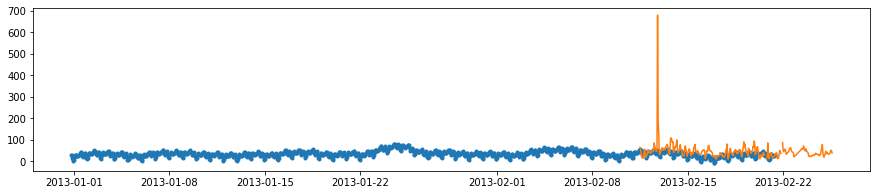

In [118]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
plt.plot(data.ds[1001:1340],data.y[1001:1340])